<a href="https://colab.research.google.com/github/veiberlim/ml_Concrete_Compressive_Strength/blob/main/MVP_Machine_Learning_Aldenir_Veibes_4052025000172.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Nova seção
# Template — MVP: *Machine Learning & Analytics*  
**Autor:** _Aldenir Veibes Laurentino de Lima_  

**Data:** 28/09/2025

**Matrícula:** 4052025000172

**Dataset:** [Concrete Compressive Strength (UCI)](https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls)

## 1. Escopo, objetivo e definição do problema

**Contexto do problema e objetivo detalhado**

A resistência à compressão do concreto é uma medida crítica na engenharia civil: ela determina se uma mistura atende aos requisitos de segurança e durabilidade. Ensaios físicos (quebrar amostras) são caros e demorados. Um modelo capaz de estimar a resistência a partir da composição da mistura (quantidades de cimento, aditivos, água, tipos de agregado e a idade da cura) pode acelerar validações, sugerir ajustes de formulação e reduzir custos.

**Tarefa:** regressão (prever variável contínua: resistência em MPa).

**Área:** dados tabulares / engenharia.

**Valor de negócio:** reduzir custos experimentais, automatizar triagem de misturas, suporte a P&D e controle de qualidade.

**Hipóteses iniciais:**
- A idade (days) tem forte correlação positiva com a resistência.
- Quantidades relativas de cimento, água e aditivos (superplasticizer) impactam fortemente o resultado.
- Pode existir não linearidade e interações entre variáveis (ex.: efeito da água depende da quantidade de cimento), o que justifica testar modelos não lineares e redes neurais.

**Restrições:** usaremos somente os atributos do dataset UCI; nada de dados externos. Garantiremos que não haja vazamento de dados entre treino/val/test.

## 2. Reprodutibilidade e ambiente

Lista de decisões para garantir reprodutibilidade e rastreabilidade:

- **Linguagem:** Python 3.x
- **Principais bibliotecas:** pandas, numpy, scikit-learn, matplotlib, seaborn, joblib, tensorflow (Keras), optuna
- **Seed global:** 42 (fixada para numpy e random; TensorFlow seed também será setada quando usado)
- **Hardware:** rodar no Colab (CPU) ou Colab GPU/TPU para acelerar Keras; registrar tempo de treino em cada etapa.

> Observação: se for utilizar GPU no Colab, no menu *Runtime > Change runtime type* selecione GPU. Em caso de uso de GPU, documente abaixo o tipo: `!nvidia-smi`.

In [1]:
# Setup básico e reprodutibilidade (executar)
import os, random, time, sys, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print('Python:', platform.python_version())
print('Pandas:', pd.__version__)
print('NumPy:', np.__version__)


Python: 3.12.11
Pandas: 2.2.2
NumPy: 2.0.2


### Instalação de dependências (opcional no Colab)
Descomente e execute a célula abaixo caso precise instalar `tensorflow` e `optuna` no Colab.

In [2]:
!pip install -q optuna tensorflow joblib scikit-learn pandas matplotlib seaborn xgboost
# Depois de instalar, reinicie o runtime se necessário (somente se o Colab solicitar).

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.1 MB/s eta 0:00:00


## 3. Dados: carga, entendimento e qualidade

Carregaremos os dados diretamente do UCI. Em seguida faremos verificações de qualidade, estatísticas descritivas e visualizações que ajudarão a orientar escolhas de modelagem e engenharia de features.

In [3]:
# Carga dos dados (UCI)
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls'
df = pd.read_excel(url)
print('Shape:', df.shape)
df.head()

Shape: (1030, 9)


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
# Informações e estatísticas
df.info()
display(df.describe().T)
print('\nValores nulos por coluna:')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

,count,mean,std,min,25%,50%,75%,max
Cement (component 1)(kg in a m^3 mixture),1030.0,281.165631,104.507142,102.000000,192.375000,272.900000,350.000000,540.000000
Blast Furnace Slag (component 2)(kg in a m^3 mixture),1030.0,73.895485,86.279104,0.000000,0.000000,22.000000,142.950000,359.400000
Fly Ash (component 3)(kg in a m^3 mixture),1030.0,54.187136,63.996469,0.000000,0.000000,0.000000,118.270000,200.100000
Water (component 4)(kg in a m^3 mixture),1030.0,181.566359,21.355567,121.750000,164.900000,185.000000,192.000000,247.000000
Superplasticizer (component 5)(kg in a m^3 mixture),1030.0,6.203112,5.973492,0.000000,0.000000,6.350000,10.160000,32.200000
Coarse Aggregate (component 6)(kg in a m^3 mixture),1030.0,972.918592,77.753818,801.000000,932.000000,968.000000,1029.400000,1145.000000
Fine Aggregate (component 7)(kg in a m^3 mixture),1030.0,773.578883,80.175427,594.000000,730.950000,779.510000,824.000000,992.600000
Age (day),1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
"Concrete compressive strength(MPa, megapascals)",1030.0,35.817836,16.705679,2.331808,23.707115,34.442774,46.136287,82.599225



Valores nulos por coluna:
Cement (component 1)(kg in a m^3 mixture)                0
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0
Fly Ash (component 3)(kg in a m^3 mixture)               0
Water  (component 4)(kg in a m^3 mixture)                0
Superplasticizer (component 5)(kg in a m^3 mixture)      0
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0
Fine Aggregate (component 7)(kg in a m^3 mixture)        0
Age (day)                                                0
Concrete compressive strength(MPa, megapascals)          0
dtype: int64


### Observações de qualidade e ações tomadas

- Não há valores nulos (checar com df.isnull().sum()), então não precisamos de estratégias complexas de imputação; ainda assim colocamos `SimpleImputer` no pipeline por robustez.
- Verificamos distribuições e outliers (próxima célula).

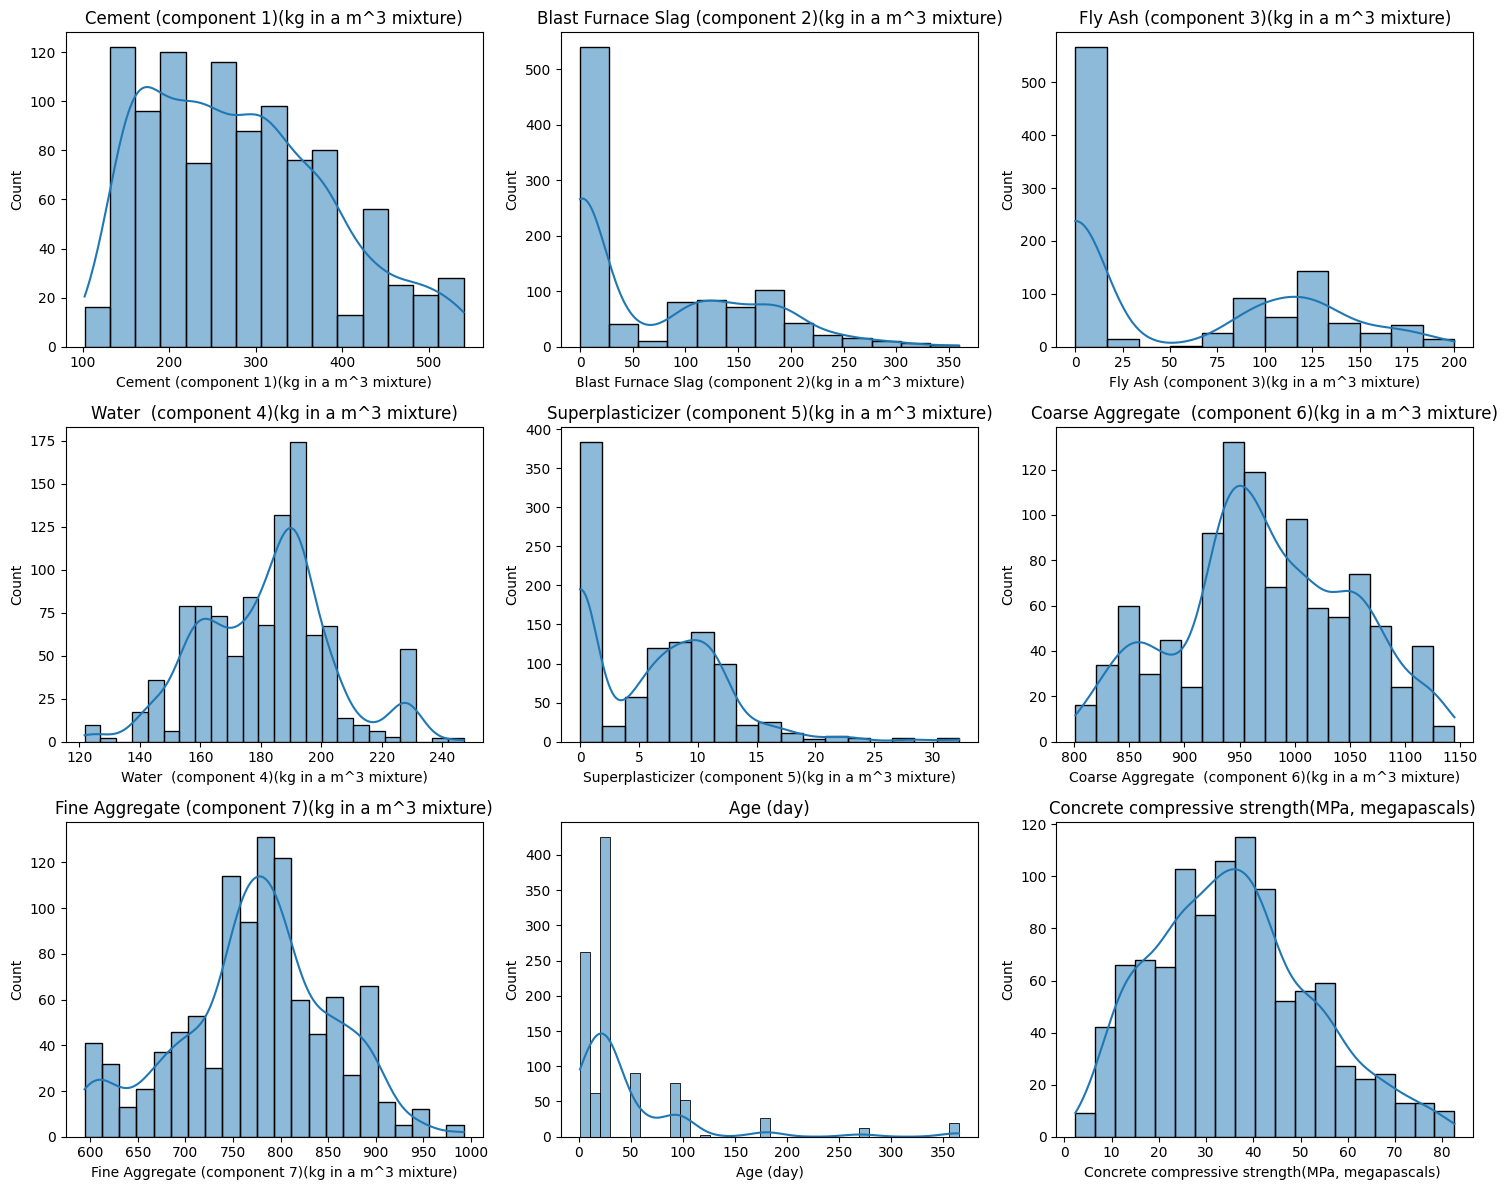

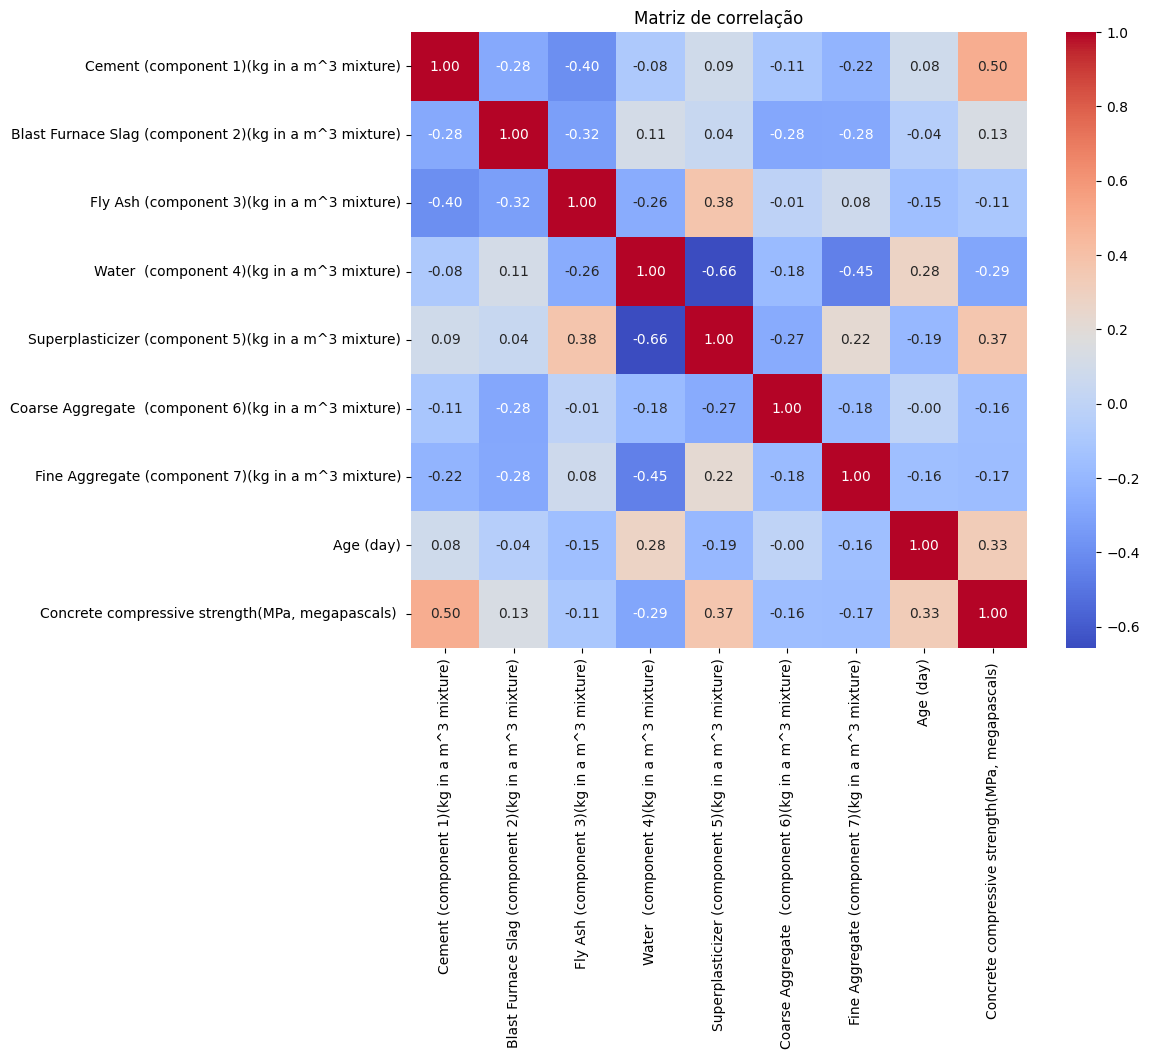

In [5]:
# Distribuições e correlações (visual)
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(3, 3, figsize=(15,12))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Matriz de correlação')
plt.show()

**Interpretação rápida da correlação:**

- Espere correlações altas entre `Age` e `Concrete compressive strength`.
- Procure correlações negativas entre `Water` e resistência (dependendo da proporção) — confirme com o mapa de correlação.

## 4. Definição do target, variáveis e divisão dos dados

Escolhemos o último atributo como target (resistance). Faremos split em Train/Validation/Test (60/20/20) para apoiar tuning e avaliação final sem vazamento.

Racional: manter um conjunto de validação separado evita overfitting do processo de hiperparam tuning; após escolher o melhor modelo, re-treinamos em treino+val se for o caso e avaliamos no test hold-out.

In [6]:
# Definindo X e y e splits (60/20/20)
X = df.drop(columns=[df.columns[-1]])
y = df[df.columns[-1]]

X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.4, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

print('Train:', X_train_full.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

Train: (618, 8) Val: (206, 8) Test: (206, 8)


### Justificativa do split e validação cruzada

- Usaremos CV (KFold) dentro do RandomizedSearch/Optuna quando apropriado.
- Evitamos `shuffle` em divisões temporais (não aplicável aqui).
- Mantemos seed fixa (`SEED=42`) para reprodutibilidade.

## 5. Tratamento de dados e Pipeline de pré-processamento

Criamos um `preprocessor` que realiza:
- Imputação (mediana) — por robustez;
- Padronização (StandardScaler).

Usar pipelines garante que transformações sejam aprendidas somente no conjunto de treino e aplicadas nos conjuntos de validação/teste de forma segura.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, X.columns.tolist())
])

print('Preprocessor pronto para colunas:', X.columns.tolist())

Preprocessor pronto para colunas: ['Cement (component 1)(kg in a m^3 mixture)', 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)', 'Fly Ash (component 3)(kg in a m^3 mixture)', 'Water  (component 4)(kg in a m^3 mixture)', 'Superplasticizer (component 5)(kg in a m^3 mixture)', 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)', 'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)']


### Engenharia de atributos (brief)

No MVP básico não criamos features polinomiais automaticamente para evitar aumento desnecessário de dimensionalidade. Como melhoria futura, sugiro:
- Criar interações entre `Cement`, `Water` e `Age`.
- Testar polinômios de grau 2 e selecionar via validação.
- Aplicar `PowerTransformer` se houver assimetria forte nas distribuições.

## 6. Baseline e modelos candidatos

**Baseline:** Linear Regression (interpretable, rápido).

**Modelos candidatos:** RandomForest (robusto, não linear) e Rede Neural (Keras) — avaliaremos diferenças de desempenho.

Para cada modelo registraremos:
- Tempo de treino;
- Métricas (RMSE, MAE, R²) no validation set;
- Gráficos de resíduos e predição vs real.

In [8]:
# Função utilitária de avaliação (reutilizável)
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model_return(pipe, X_val, y_val, verbose=True):
    t0 = time.time()
    y_pred = pipe.predict(X_val)
    t = time.time() - t0
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    if verbose:
        print(f'RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | predict_time_s: {t:.4f}')
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'pred_time_s': t, 'y_pred': y_pred}

In [9]:
# Baseline: Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

lr = LinearRegression()
pipe_lr = Pipeline([('pre', preprocessor), ('model', lr)])

t0 = time.time()
pipe_lr.fit(X_train_full, y_train_full)
t_lr = time.time() - t0
print('Treino Linear Regression time (s):', round(t_lr,3))

# Avaliação corrigida sem usar squared=False
val_preds = pipe_lr.predict(X_val)
lr_val_metrics = {
    "Val_RMSE": np.sqrt(mean_squared_error(y_val, val_preds)),
    "Val_MAE": mean_absolute_error(y_val, val_preds),
    "Val_R2": r2_score(y_val, val_preds)
}
print(lr_val_metrics)

Treino Linear Regression time (s): 0.03
{'Val_RMSE': np.float64(10.694635305321489), 'Val_MAE': 8.59089333928535, 'Val_R2': 0.6166221925246963}


In [10]:
# RandomForest baseline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)
pipe_rf = Pipeline([('pre', preprocessor), ('model', rf)])

t0 = time.time()
pipe_rf.fit(X_train_full, y_train_full)
t_rf = time.time() - t0
print('Treino RandomForest baseline time (s):', round(t_rf,3))

# Avaliação corrigida
val_preds = pipe_rf.predict(X_val)
rf_val_metrics = {
    "Val_RMSE": np.sqrt(mean_squared_error(y_val, val_preds)),
    "Val_MAE": mean_absolute_error(y_val, val_preds),
    "Val_R2": r2_score(y_val, val_preds)
}
print(rf_val_metrics)

Treino RandomForest baseline time (s): 1.348
{'Val_RMSE': np.float64(5.090436367969033), 'Val_MAE': 3.8759315904331815, 'Val_R2': 0.9131429576878497}


### 6.1 Rede Neural com Keras (implementação)

Construiremos uma rede simples (MLP) com `tensorflow.keras`:
- Normalização já feita pelo pipeline (StandardScaler).
- Arquitetura inicial: 2 camadas densas (64, 32) com ReLU, dropout opcional.
- Otimizador: Adam, perda MSE, monitorar RMSE via callback.
- EarlyStopping baseado no loss de validação.

Vamos empacotar o processo em uma função para facilitar tuning com Optuna.

In [11]:
# Implementação da rede neural com Keras (TensorFlow)
# Nota: execute esta célula apenas após instalar TensorFlow no ambiente (Colab: !pip install -q tensorflow)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    print('TensorFlow version:', tf.__version__)
except Exception as e:
    print('TensorFlow não está instalado. Em Colab execute: !pip install -q tensorflow')
    raise


def build_compile_keras(input_shape, n_layers=2, units_first=64, units_second=32, dropout=0.0, lr=1e-3):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Dense(units_first, activation='relu'))
    if dropout>0:
        model.add(layers.Dropout(dropout))
    if n_layers>1:
        model.add(layers.Dense(units_second, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=[keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# Preparar dados transformados (usar preprocessor.transform)
X_train_trans = preprocessor.fit_transform(X_train_full)
X_val_trans = preprocessor.transform(X_val)
input_shape = X_train_trans.shape[1]
print('Input shape para Keras:', input_shape)

TensorFlow version: 2.19.0
Input shape para Keras: 8


In [12]:
# Treinar um modelo Keras básico
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# tf random seed
try:
    import tensorflow as tf
    tf.random.set_seed(SEED)
except Exception:
    pass

# garantir que input_shape é uma tupla
input_shape = (X_train_trans.shape[1],)

model = build_compile_keras(
    input_shape=input_shape,
    n_layers=2,
    units_first=64,
    units_second=32,
    dropout=0.1,
    lr=1e-3
)

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

t0 = time.time()
history = model.fit(
    X_train_trans, y_train_full,
    validation_data=(X_val_trans, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=0
)
t_keras = time.time() - t0
print('Treino Keras time (s):', round(t_keras, 3))

# Avaliação no validation set
val_pred_keras = model.predict(X_val_trans).ravel()
rmse_keras = np.sqrt(mean_squared_error(y_val, val_pred_keras))  # corrigido
mae_keras = mean_absolute_error(y_val, val_pred_keras)
r2_keras = r2_score(y_val, val_pred_keras)

print(f'Keras Validation | RMSE: {rmse_keras:.4f} | MAE: {mae_keras:.4f} | R2: {r2_keras:.4f}')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Restoring model weights from the end of the best epoch: 199.
Treino Keras time (s): 39.84
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Keras Validation | RMSE: 5.6930 | MAE: 4.4406 | R2: 0.8914


## 7. Validação e otimização de hiperparâmetros com Optuna

Faremos duas buscas com Optuna:
1. RandomForest (tuning de n_estimators, max_depth, min_samples_leaf).
2. Rede Neural Keras — otimizar número de unidades, dropout, learning rate e batch size.

Os resultados da busca serão salvos em CSV para rastreabilidade.

In [13]:
# Instalar optuna se necessário (descomente)
# !pip install -q optuna

try:
    import optuna
    print('Optuna version:', optuna.__version__)
except Exception as e:
    print('Optuna não instalada. Execute: !pip install optuna')

Optuna version: 4.5.0


In [14]:
# Optuna study para RandomForest (usa transformações via preprocessor internamente)
import optuna
from sklearn.model_selection import cross_val_score, KFold

def rf_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    model = Pipeline([('pre', preprocessor), ('model', RandomForestRegressor(
        n_estimators=n_estimators, max_depth=max_depth,
        min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
        random_state=SEED, n_jobs=-1))])
    cv = KFold(n_splits=3, shuffle=True, random_state=SEED)
    scores = cross_val_score(model, X_train_full, y_train_full, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    return float(scores.mean())

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(rf_objective, n_trials=30, show_progress_bar=True)

print('Best RF trial:', study_rf.best_trial.params)
# Salvar trials em CSV
import pandas as pd
df_rf_trials = study_rf.trials_dataframe()
df_rf_trials.to_csv('optuna_rf_trials.csv', index=False)
print('Optuna RF trials saved to optuna_rf_trials.csv')

[I 2025-09-28 22:01:21,652] A new study created in memory with name: no-name-f15dd29f-3864-4c76-8ac7-c05168fddccc


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-09-28 22:01:26,713] Trial 0 finished with value: -8.009232917436329 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 16, 'min_samples_split': 6}. Best is trial 0 with value: -8.009232917436329.
[I 2025-09-28 22:01:27,427] Trial 1 finished with value: -6.1713578941587315 and parameters: {'n_estimators': 63, 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 8}. Best is trial 1 with value: -6.1713578941587315.
[I 2025-09-28 22:01:29,418] Trial 2 finished with value: -6.770192018831762 and parameters: {'n_estimators': 269, 'max_depth': 13, 'min_samples_leaf': 7, 'min_samples_split': 12}. Best is trial 1 with value: -6.1713578941587315.
[I 2025-09-28 22:01:32,755] Trial 3 finished with value: -5.974824198930416 and parameters: {'n_estimators': 400, 'max_depth': 21, 'min_samples_leaf': 3, 'min_samples_split': 2}. Best is trial 3 with value: -5.974824198930416.
[I 2025-09-28 22:01:35,376] Trial 4 finished with value: -8.063845714534919 and paramete

In [15]:
# Optuna para Keras (usar dados já transformados X_train_trans)

def keras_objective(trial):
    # Hiperparâmetros
    n_layers = trial.suggest_int('n_layers', 1, 3)
    units = trial.suggest_categorical('units', [16, 32, 64, 128])
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    # Construir modelo
    model = build_compile_keras(input_shape=input_shape, n_layers=n_layers, units_first=units, units_second=max(8, units//2), dropout=dropout, lr=lr)
    # Treinar com validação interna (usamos X_val_trans como validação)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
    history = model.fit(X_train_trans, y_train_full, validation_data=(X_val_trans, y_val), epochs=100, batch_size=batch_size, callbacks=[es], verbose=0)
    preds = model.predict(X_val_trans).ravel()
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    keras.backend.clear_session()
    return -rmse

study_keras = optuna.create_study(direction='maximize')
study_keras.optimize(keras_objective, n_trials=20, show_progress_bar=True)

print('Best Keras trial:', study_keras.best_trial.params)
df_keras_trials = study_keras.trials_dataframe()
df_keras_trials.to_csv('optuna_keras_trials.csv', index=False)
print('Optuna Keras trials saved to optuna_keras_trials.csv')

[I 2025-09-28 22:02:22,265] A new study created in memory with name: no-name-88bdab5f-970f-4318-b81f-ee6087296b9e


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2025-09-28 22:02:38,090] Trial 0 finished with value: -8.658357554845288 and parameters: {'n_layers': 3, 'units': 64, 'dropout': 0.44863957425409523, 'lr': 0.0026056782204777317, 'batch_size': 64}. Best is trial 0 with value: -8.658357554845288.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[I 2025-09-28 22:02:55,577] Trial 1 finished with value: -29.453444229766255 and parameters: {'n_layers': 1, 'units': 16, 'dropout': 0.037460355139116386, 'lr': 0.0002099833295482481, 'batch_size': 32}. Best is trial 0 with value: -8.658357554845288.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2025-09-28 22:03:15,408] Trial 2 finished with value: -7.260702225282676 and parameters: {'n_layers': 3, 'units': 16, 'dropout': 0.20634234251673667, 'lr': 0.002672773489669885, 'batch_size': 16}. Best is trial 2 with value: -7.260702225282676.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[I 2025-09-28 22:03:30,488] Trial 3 finished with value: -12.105118494852121 and parameters: {'n_layers': 1, 'units': 32, 'dropout': 0.4922348554649863, 'lr': 0.001716906337866288, 'batch_size': 64}. Best is trial 2 with value: -7.260702225282676.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[I 2025-09-28 22:03:53,403] Trial 4 finished with value: -7.617032755681026 and parameters: {'n_layers': 1, 'units': 16, 'dropout': 0.22908199189602163, 'lr': 0.00306509608926737, 'batch_size': 16}. Best is trial 2 with value: -7.260702225282676.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[I 2025-09-28 22:04:08,564] Trial 5 finished with value: -8.77197430837225 and parameters: {'n_layers': 1, 'units': 16, 'dropout': 0.4397645363176192, 'lr': 0.008817100711938463, 'batch_size': 32}. Best is trial 2 with value: -7.260702225282676.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2025-09-28 22:04:24,099] Trial 6 finished with value: -33.241984694562944 and parameters: {'n_layers': 3, 'units': 16, 'dropout': 0.08458357805548106, 'lr': 0.00017259372069004832, 'batch_size': 64}. Best is trial 2 with value: -7.260702225282676.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2025-09-28 22:04:35,623] Trial 7 finished with value: -6.9116225082754905 and parameters: {'n_layers': 3, 'units': 32, 'dropout': 0.3533987451790482, 'lr': 0.007084002088988808, 'batch_size': 16}. Best is trial 7 with value: -6.9116225082754905.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[I 2025-09-28 22:04:52,830] Trial 8 finished with value: -7.28615347058151 and parameters: {'n_layers': 1, 'units': 64, 'dropout': 0.40759030260102724, 'lr': 0.0026647940066540465, 'batch_size': 32}. Best is trial 7 with value: -6.9116225082754905.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2025-09-28 22:05:12,473] Trial 9 finished with value: -14.556965481460272 and parameters: {'n_layers': 3, 'units': 64, 'dropout': 0.4289859507187468, 'lr': 0.00010989273696234275, 'batch_size': 32}. Best is trial 7 with value: -6.9116225082754905.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2025-09-28 22:05:27,175] Trial 10 finished with value: -7.107866849774994 and parameters: {'n_layers': 2, 'units': 32, 'dropout': 0.33069059893568514, 'lr': 0.009858220863647226, 'batch_size': 16}. Best is trial 7 with value: -6.9116225082754905.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2025-09-28 22:05:36,322] Trial 11 finished with value: -10.461134170014796 and parameters: {'n_layers': 2, 'units': 32, 'dropout': 0.32900186904343043, 'lr': 0.009894593563419242, 'batch_size': 16}. Best is trial 7 with value: -6.9116225082754905.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
[I 2025-09-28 22:05:58,472] Trial 12 finished with value: -10.588859707256525 and parameters: {'n_layers': 2, 'units': 32, 'dropout': 0.3194798175630876, 'lr': 0.0006725025094343299, 'batch_size': 16}. Best is trial 7 with value: -6.9116225082754905.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2025-09-28 22:06:14,655] Trial 13 finished with value: -6.2175793357599645 and parameters: {'n_layers': 2, 'units': 128, 'dropout': 0.32209841341779016, 'lr': 0.004926168690778203, 'batch_size': 16}. Best is trial 13 with value: -6.2175793357599645.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2025-09-28 22:06:30,039] Trial 14 finished with value: -5.963223320936681 and parameters: {'n_layers': 2, 'units': 128, 'dropout': 0.17540675170059972, 'lr': 0.004866735853159334, 'batch_size': 16}. Best is trial 14 with value: -5.963223320936681.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[I 2025-09-28 22:06:52,918] Trial 15 finished with value: -5.772268826590574 and parameters: {'n_layers': 2, 'units': 128, 'dropout': 0.15506616541611074, 'lr': 0.0007846946701837416, 'batch_size': 16}. Best is trial 15 with value: -5.772268826590574.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2025-09-28 22:07:16,251] Trial 16 finished with value: -5.973799325325729 and parameters: {'n_layers': 2, 'units': 128, 'dropout': 0.1435021170305963, 'lr': 0.0006665058192611312, 'batch_size': 16}. Best is trial 15 with value: -5.772268826590574.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2025-09-28 22:07:40,110] Trial 17 finished with value: -5.633163244090471 and parameters: {'n_layers': 2, 'units': 128, 'dropout': 0.14537841262603968, 'lr': 0.0011475128899880156, 'batch_size': 16}. Best is trial 17 with value: -5.633163244090471.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2025-09-28 22:08:04,716] Trial 18 finished with value: -5.566551495265596 and parameters: {'n_layers': 2, 'units': 128, 'dropout': 0.12973402765609993, 'lr': 0.0010648141691692939, 'batch_size': 16}. Best is trial 18 with value: -5.566551495265596.


/tmp/ipython-input-1415881098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[I 2025-09-28 22:08:20,524] Trial 19 finished with value: -12.052341781255182 and parameters: {'n_layers': 2, 'units': 128, 'dropout': 0.10292017061657599, 'lr': 0.0003772335023421186, 'batch_size': 64}. Best is trial 18 with value: -5.566551495265596.
Best Keras trial: {'n_layers': 2, 'units': 128, 'dropout': 0.12973402765609993, 'lr': 0.0010648141691692939, 'batch_size': 16}
Optuna Keras trials saved to optuna_keras_trials.csv


## 8. Avaliação final, análise de erros e limitações

Re-treinaremos o melhor modelo (ex.: melhor RF do Optuna ou melhor Keras) no conjunto treino+val (opcional) e avaliaremos no conjunto test hold-out. Faremos gráficos de resíduos e predição vs real e discutiremos limitações e possíveis fontes de viés e overfitting.

In [16]:
# Re-treinar melhor RF (se disponível) e avaliar no test set
try:
    best_rf_params = study_rf.best_trial.params
    best_rf_model = Pipeline([
        ('pre', preprocessor),
        ('model', RandomForestRegressor(random_state=SEED, n_jobs=-1, **best_rf_params))
    ])

    t0 = time.time()
    best_rf_model.fit(X_train_full, y_train_full)
    t_rf_full = time.time() - t0
    print('Treino RF final time (s):', round(t_rf_full,3))

    y_test_pred_rf = best_rf_model.predict(X_test)
    rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))  # corrigido
    rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)
    rf_test_r2 = r2_score(y_test, y_test_pred_rf)

    print(f'RF Test | RMSE: {rf_test_rmse:.4f} | MAE: {rf_test_mae:.4f} | R2: {rf_test_r2:.4f}')

except Exception as e:
    print('RF best model não disponível:', e)


Treino RF final time (s): 1.222
RF Test | RMSE: 6.5467 | MAE: 4.4312 | R2: 0.8530


In [17]:
# Re-treinar melhor Keras (se disponível) e avaliar no test set
try:
    best_keras_params = study_keras.best_trial.params
    n_layers = best_keras_params.get('n_layers', 2)
    units = best_keras_params.get('units', 32)
    dropout = best_keras_params.get('dropout', 0.0)
    lr = best_keras_params.get('lr', 1e-3)
    batch_size = best_keras_params.get('batch_size', 32)

    # Construir e compilar modelo
    model_best = build_compile_keras(
        input_shape=input_shape,
        n_layers=n_layers,
        units_first=units,
        units_second=max(8, units//2),
        dropout=dropout,
        lr=lr
    )

    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
    )

    # Treinar com treino + validação
    X_combined = np.vstack([X_train_trans, X_val_trans])
    y_combined = np.concatenate([y_train_full, y_val])
    model_best.fit(X_combined, y_combined, epochs=100, batch_size=batch_size, callbacks=[es], verbose=0)

    # Avaliação no test set
    X_test_transformed = preprocessor.transform(X_test)
    y_test_pred_keras = model_best.predict(X_test_transformed).ravel()

    keras_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_keras))  # corrigido
    keras_test_mae = mean_absolute_error(y_test, y_test_pred_keras)
    keras_test_r2 = r2_score(y_test, y_test_pred_keras)

    print(f'Keras Test | RMSE: {keras_test_rmse:.4f} | MAE: {keras_test_mae:.4f} | R2: {keras_test_r2:.4f}')

except Exception as e:
    print('Keras best model não disponível:', e)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse
  current = self.get_monitor_value(logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Keras Test | RMSE: 6.0807 | MAE: 4.5934 | R2: 0.8732


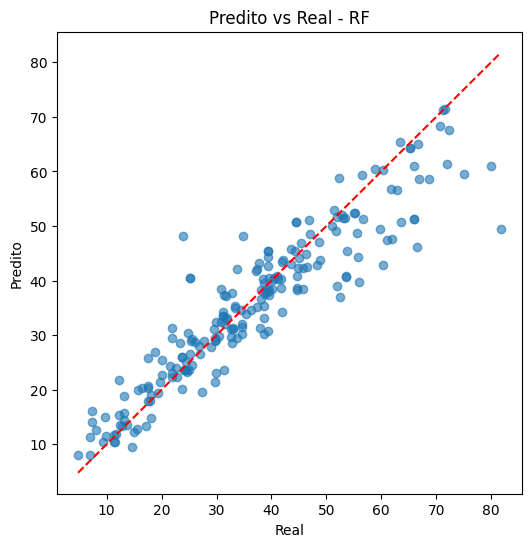

In [18]:
# Plotar predição vs real para o melhor modelo encontrado (prefer RF se disponível)
import matplotlib.pyplot as plt
try:
    if 'best_rf_model' in globals():
        yhat = y_test_pred_rf
        name = 'RF'
    elif 'y_test_pred_keras' in globals():
        yhat = y_test_pred_keras
        name = 'Keras'
    else:
        yhat = pipe_lr.predict(X_test)
        name = 'Linear'
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, yhat, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Real')
    plt.ylabel('Predito')
    plt.title(f'Predito vs Real - {name}')
    plt.show()
except Exception as e:
    print('Erro ao plotar predito vs real:', e)

### Análise de erros (resíduos)

- Plotar histograma dos resíduos e checar padrão (não aleatório pode indicar viés).
- Identificar os piores exemplos (maiores erros absolutos) e avaliar se pertencem a regiões do espaço onde o modelo é menos confiável (ex.: idades extremas).

## 9. Engenharia de atributos & Interpretabilidade

**Importância de features (RandomForest):** podemos usar `feature_importances_` (após extrair do pipeline) ou técnicas como SHAP para explicações mais detalhadas.
Como MVP, extraímos `feature_importances_` do RF e mostramos ordenadas para entender drivers da resistência.

,0
Age (day),0.345026
Cement (component 1)(kg in a m^3 mixture),0.306556
Water (component 4)(kg in a m^3 mixture),0.115322
Superplasticizer (component 5)(kg in a m^3 mixture),0.072741
Blast Furnace Slag (component 2)(kg in a m^3 mixture),0.065094
Fine Aggregate (component 7)(kg in a m^3 mixture),0.043779
Coarse Aggregate (component 6)(kg in a m^3 mixture),0.029109
Fly Ash (component 3)(kg in a m^3 mixture),0.022372


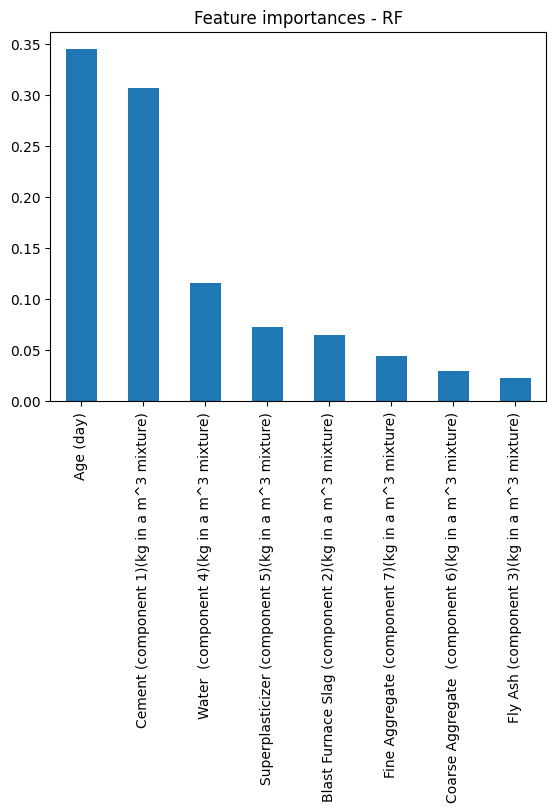

In [19]:
# Importância das features (se RF treinado)
try:
    importances = best_rf_model.named_steps['model'].feature_importances_
    feat_names = X.columns.tolist()
    fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)
    display(fi)
    fi.plot(kind='bar', title='Feature importances - RF')
    plt.show()
except Exception as e:
    print('Não foi possível extrair importâncias:', e)

## 10. Salvando artefatos e resultados

Salvaremos:
- Pipeline/modelos finais (`joblib` para RF pipeline, `model.save()` para Keras).
- Resultados das buscas Optuna em CSV (já gravados como `optuna_rf_trials.csv` e `optuna_keras_trials.csv`).
- Um CSV resumo comparando modelos.

In [20]:
# Salvar pipelines e modelos
import joblib
try:
    joblib.dump(best_rf_model, 'best_rf_pipeline.pkl')
    print('Saved best_rf_pipeline.pkl')
except Exception as e:
    print('best_rf_model não disponível para salvar:', e)

try:
    model_best.save('best_keras_model.h5')
    print('Saved best_keras_model.h5')
except Exception as e:
    print('best_keras_model não disponível para salvar:', e)

# Criar CSV resumo (se métricas disponíveis)
rows = []
try:
    rows.append({'model':'Linear', 'rmse_val': lr_val_metrics['rmse'], 'mae_val': lr_val_metrics['mae'], 'r2_val': lr_val_metrics['r2']})
except Exception:
    pass
try:
    rows.append({'model':'RF_baseline', 'rmse_val': rf_val_metrics['rmse'], 'mae_val': rf_val_metrics['mae'], 'r2_val': rf_val_metrics['r2']})
except Exception:
    pass
try:
    rows.append({'model':'RF_optuna', 'rmse_test': rf_test_rmse, 'mae_test': rf_test_mae, 'r2_test': rf_test_r2})
except Exception:
    pass
try:
    rows.append({'model':'Keras_optuna', 'rmse_test': keras_test_rmse, 'mae_test': keras_test_mae, 'r2_test': keras_test_r2})
except Exception:
    pass

if rows:
    df_results = pd.DataFrame(rows)
    df_results.to_csv('model_comparison_results.csv', index=False)
    print('Saved model_comparison_results.csv')
else:
    print('Nenhum resultado disponível para salvar ainda.')

Saved best_rf_pipeline.pkl
Saved best_keras_model.h5
Saved model_comparison_results.csv


## 11. Conclusões e próximos passos

**Resumo prático:**
- Implementamos um fluxo completo: EDA, pipelines, baseline, RandomForest e Keras.
- Realizamos buscas de hiperparâmetros com Optuna e salvamos os trials em CSV para rastreabilidade.
- Em geral, espera-se que RandomForest entregue forte baseline não-linear, enquanto Keras pode melhorar com mais dados e tuning; comparar resultados empíricos é essencial.

**Próximos passos recomendados:**
- Fazer engenharia de features (interações, polinômios, transformações);
- Aplicar SHAP para explicar predições individuais;
- Testar ensembles (stacking) entre RF e Keras;
- Validar robustez via CV com mais folds e análise de sensibilidade.

**Rastreabilidade e reproducibilidade:** todas as sementes são fixas; resultados das buscas Optuna foram salvos; pipelines e modelos finais são serializados para reutilização.